# Development of hit graph construction methods

This notebook will be used to develop and evaluate methods for constructing the graph of connected hits (mainly) for the segment classification model.

In [1]:
# System imports
from __future__ import print_function
import os
import multiprocessing as mp

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local imports
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [2]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [73]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

## Load the data

In [3]:
input_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'

In [4]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 1
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [5]:
# Start process pool
n_workers = 1
pool = mp.Pool(processes=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv


In [6]:
%%time

hits = process_hits_files(hits_files, pool)

CPU times: user 70.1 ms, sys: 37.5 ms, total: 108 ms
Wall time: 1min 4s


In [7]:
# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

In [8]:
# Remove all duplicate hits
hits = hits.loc[
    hits.groupby(['evtid', 'barcode', 'volid', 'layid'], as_index=False).r.idxmin()
]

In [9]:
hits.head()

,evtid,barcode,volid,layid,phi,r,z
12,0,9007611571601408,8,2,2.950620,32.226063,-47.816601
24,0,9007611571601408,8,4,2.956995,71.080132,-78.497902
39,0,9007611571601408,8,6,2.964698,115.680214,-113.727997
50,0,9007611571601408,8,8,2.974130,171.528519,-157.852005
72,0,9007611571601408,13,2,2.989005,259.310913,-230.000000


In [10]:
hits.shape

(424462, 7)

In [11]:
# Close the worker process pool
pool.close()
pool.join()

## Develop edge construction procedure.

I have thought of a way to deduce my graph connection criteria.

First, I will identify possible pairs of layers by looking at true adjacent hit pairs in the data.

Next, I will identify relevant criteria for allowed slopes of lines passing through two points in the
R-phi and R-Z planes. The cuts here can be tuned to optimize for efficiency.

### Figure out which layers should be connected

So, first, we must figure out which adjacent layer pairs exist in real tracks.
I can do this somehow by grouping hits by track, sorting by r, and pairing up the adjacent layid and volid.

In [12]:
def get_gid_pairs(x):
    gids = x.sort_values('r')[['volid', 'layid']].values
    return np.concatenate((gids[:-1], gids[1:]), axis=1)

In [13]:
par_groups = hits.groupby(['evtid', 'barcode'])
gid_pairs = np.concatenate(par_groups.apply(get_gid_pairs).values)
gid_pairs = np.unique(gid_pairs, axis=0)

In [14]:
gid_pairs.shape

(132, 4)

### Compute features of all possible segments

Now, for every layer pair, we want to pair up all hits and look at the line passing between them.

In [111]:
%%time

gid_groups = hits.groupby(['volid', 'layid'])
segments = []

for gids in gid_pairs:
    hits1 = gid_groups.get_group(tuple(gids[:2]))
    hits2 = gid_groups.get_group(tuple(gids[2:]))
    # Join all pairs together
    hit_pairs = hits1.merge(hits2, how='inner', on='evtid', suffixes=('_1', '_2'))

    # Calculate coordinate differences
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1

    # Identify the true pairs
    y = (hit_pairs.barcode_1 == hit_pairs.barcode_2)

    # phi-r slope
    phi_slopes = dphi / dr
    # R-Z intercept
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr

    # Put the results in a new dataframe
    segments.append(hit_pairs[['evtid', 'volid_1', 'layid_1', 'volid_2', 'layid_2']]
                    .assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slopes, z0=z0))

segments = pd.concat(segments, ignore_index=True)

CPU times: user 6.87 s, sys: 2.61 s, total: 9.48 s
Wall time: 9.49 s


In [112]:
segments.head()

,evtid,volid_1,layid_1,volid_2,layid_2,dphi,dr,dz,phi_slope,y,z0
0,2,7,2,12,2,-0.002429,352.419983,-1456.5,-0.000007,False,-802.120605
1,2,7,2,12,2,-0.626175,525.164246,-1447.5,-0.001192,False,-1033.904419
2,2,7,2,12,2,0.024379,169.123886,-1447.5,0.000144,True,-56.888306
3,2,7,2,12,2,-2.209933,339.397522,-1456.5,-0.006511,False,-775.420166
4,2,7,2,12,2,1.743889,471.498291,-1447.5,0.003699,False,-981.081055


Here we need to separate out the segments that hit the outer super-strips because they are very coarse in z and the z0 distribution is thus very different.

In [113]:
is_inner = (segments.volid_1 < 16) & (segments.volid_2 < 16)
inner_segments = segments[is_inner]
outer_segments = segments[is_inner == False]

<IPython.core.display.Javascript object>


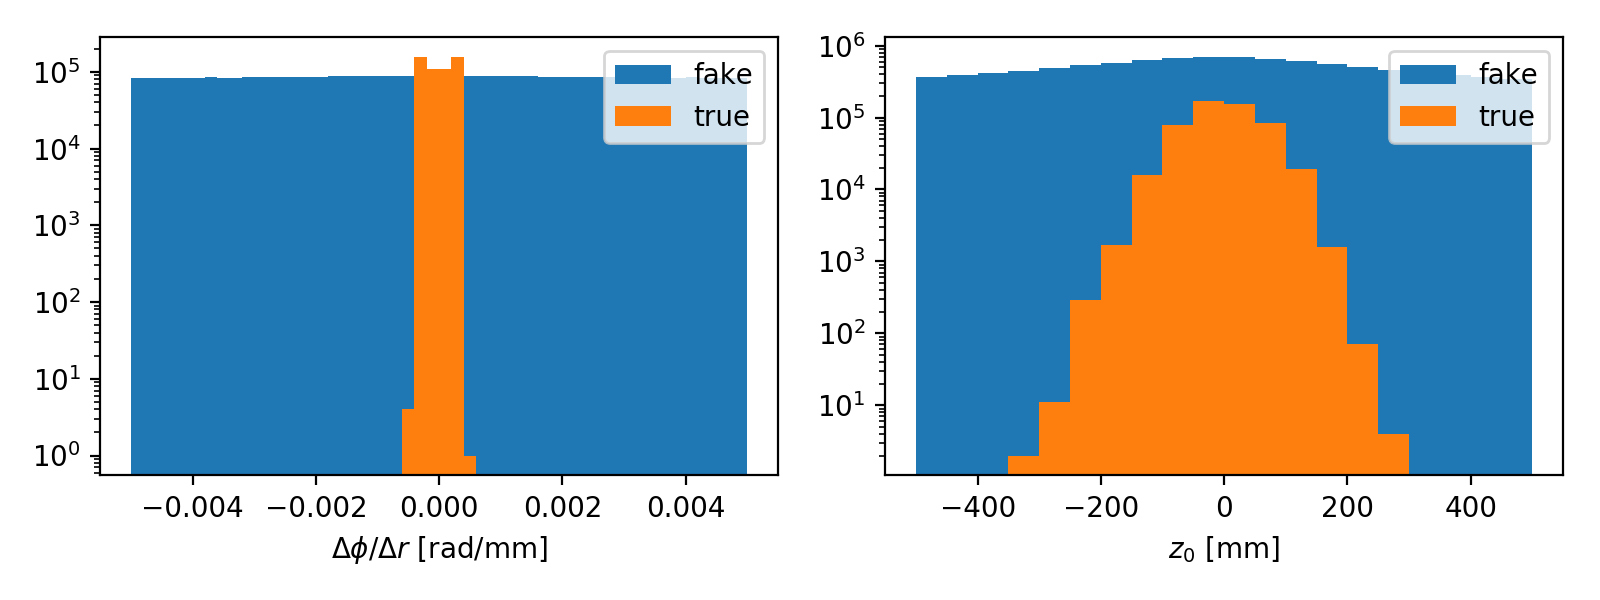

In [114]:
plt.figure(figsize=(8,3))

true_segs = inner_segments[inner_segments.y]
fake_segs = inner_segments[inner_segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.005, 0.005))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=20, range=(-500, 500))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

<IPython.core.display.Javascript object>


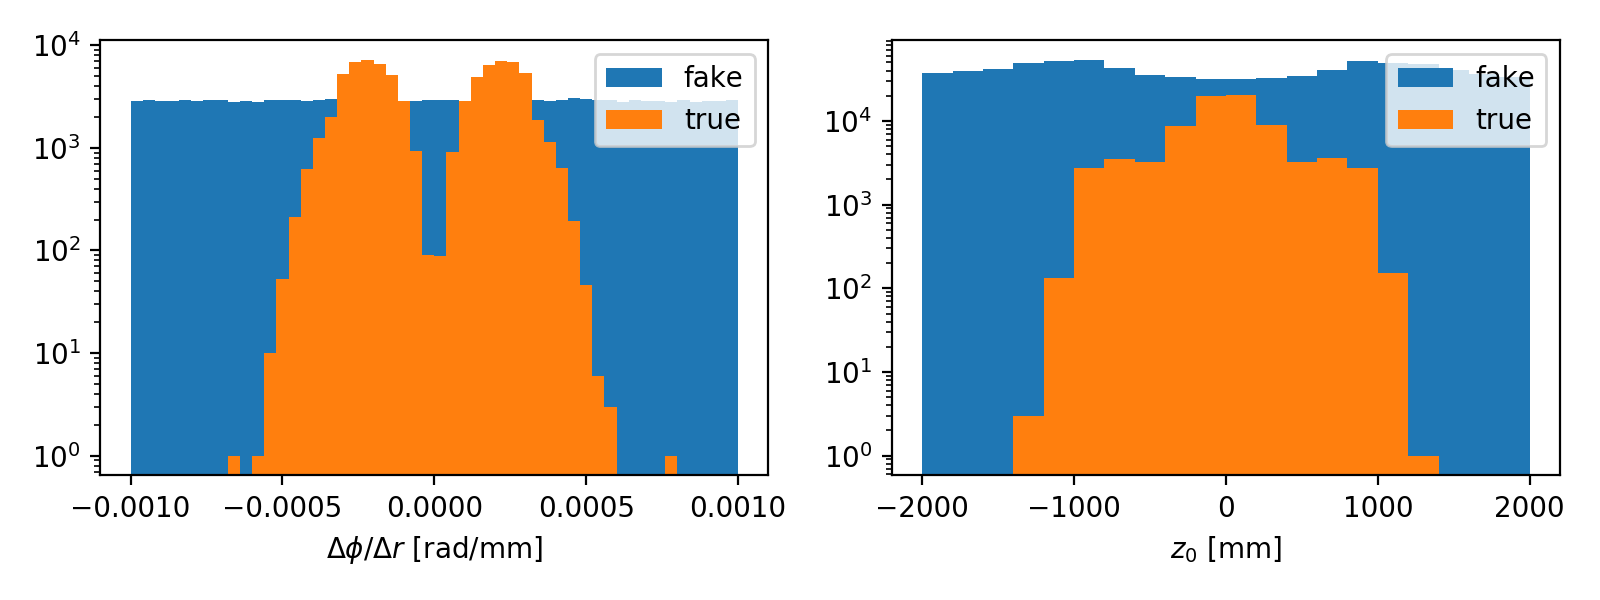

In [115]:
plt.figure(figsize=(8,3))

true_segs = outer_segments[outer_segments.y]
fake_segs = outer_segments[outer_segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.001, 0.001))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=20, range=(-2000, 2000))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

Let's investigate the segments with the largest dR. These might be weird tracks.

In [116]:
segments[segments.y].dr.describe()

count    608504.000000
mean        111.970100
std          84.260796
min        -116.877197
25%          46.828434
50%          91.264053
75%         156.082386
max         584.625305
Name: dr, dtype: float64

<IPython.core.display.Javascript object>


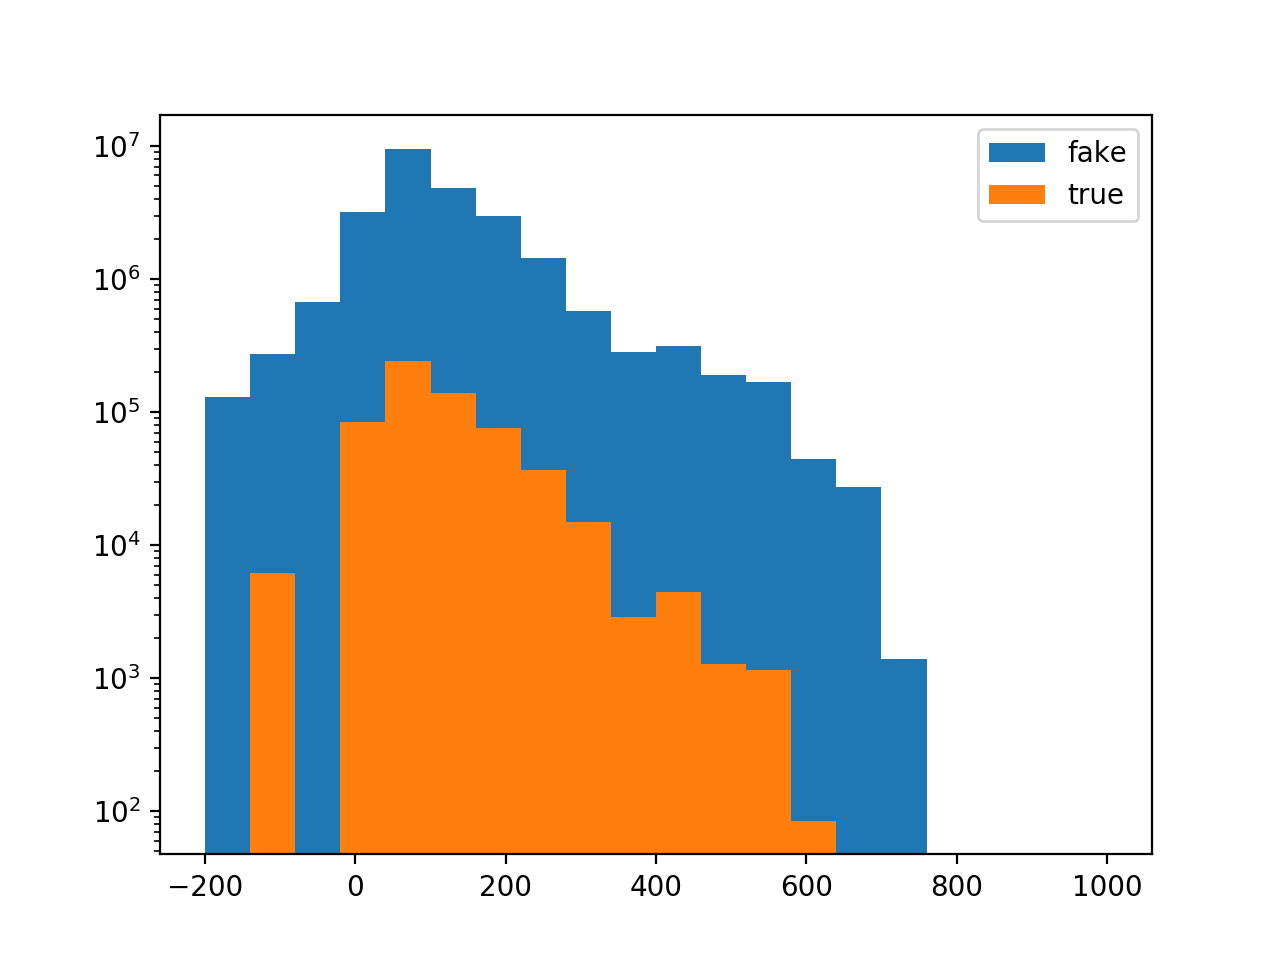

In [117]:
plt.figure()
true_segs = segments[segments.y]
fake_segs = segments[segments.y==False]
binning=dict(bins=20, range=(-200, 1000), log=True)
plt.hist(fake_segs.dr, label='fake', **binning)
plt.hist(true_segs.dr, label='true', **binning)
plt.legend()

Agh, there shouldn't be negative changes in r in the true segments. Figure out what's happening.

### Investigating negative dr segments

In [118]:
true_segs.dr.describe()

count    608504.000000
mean        111.970100
std          84.260796
min        -116.877197
25%          46.828434
50%          91.264053
75%         156.082386
max         584.625305
Name: dr, dtype: float64

In [119]:
true_segs.dr.idxmin()

25348570

In [120]:
segments.loc[true_segs.dr.idxmin()]

evtid                502
volid_1               18
layid_1                6
volid_2               18
layid_2                4
dphi           0.0320018
dr              -116.877
dz                  -305
phi_slope   -0.000273807
y                   True
z0              -664.029
Name: 25348570, dtype: object

Hmmm, ok.  It seems like there are some odd layer pairs in the outer strips. These might be due to some strange rare tracks that fell near the middle of the strips and bent slightly backwards in z to hit them in the non-standard order. This is an issue because it will give me duplicate segments. I should at the very least take care to remove duplicate layer pairs.

Maybe I should make counts of the layer pairs and apply a threshold to remove the odd ones. This will result in a slight inefficiency but probably acceptable.

Another thing I could do is compare counts only when there are redundancies.

Let's play with this some more right here before exporting an improved method back to the above spot.

In [ ]:
par_groups = hits.groupby(['evtid', 'barcode'])

In [136]:
def get_gid_df(x):
    gids = x.sort_values('r')[['volid', 'layid']]
    g1 = gids.iloc[:-1]
    g2 = gids.iloc[1:]    
    return pd.DataFrame(data=dict(volid_1=g1.volid.values, layid_1=g1.layid.values,
                                  volid_2=g2.volid.values, layid_2=g2.layid.values))

In [137]:
%%time

gid_df = par_groups.apply(get_gid_df)

CPU times: user 1min 16s, sys: 1.09 s, total: 1min 17s
Wall time: 1min 17s


In [150]:
pd.Series.reset_index?

In [163]:
gid_counts = gid_df.groupby(['volid_1', 'layid_1', 'volid_2', 'layid_2']).size().reset_index(name='n')

In [164]:
gid_counts.n

0          1
1        734
2        329
3       1049
4        849
5       1178
6         31
7         15
8       3005
9         53
10       837
11       102
12      3798
13       468
14       579
15       112
16      4840
17       744
18       284
19       107
20      5870
21        15
22      1006
23      2559
24     37613
25         1
26      2478
27         4
28       110
29      3000
       ...  
102     6076
103      672
104      554
105     6067
106      495
107      611
108     5811
109      507
110      155
111      961
112       63
113        1
114      879
115       41
116      841
117       21
118      791
119      659
120      584
121    13499
122      598
123      619
124      747
125       24
126      818
127       36
128      878
129       57
130      938
131      126
Name: n, Length: 132, dtype: int64

### Decide on some edge criteria

It looks like I could use criteria like these to construct the graph:
- ($\Delta \phi / \Delta r$) < 0.001
- $|z_0| < 400$ if neither hits are on super-strips
- $|z_0| < 1500$ if one or both hits are on super-strips

## Construct graphs

Let's apply the procedure to construct graphs in the data, and then evaluate the purity/efficiency of the segments.

In [20]:
gid_groups = hits.groupby(['volid', 'layid'])

In [65]:
%%time

# Store all segments here
segments = []

# Loop over geometry IDs
for (vol1, lay1, vol2, lay2) in gid_pairs:
    # Prepare all hit pairs
    hits1 = gid_groups.get_group((vol1, lay1))
    hits2 = gid_groups.get_group((vol2, lay2))
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))

    # Calculate coordinate features
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    
    # Filter on phi slope and z0
    phi_slope_max = 0.001
    z0_max = 1500 if (vol1 >= 16) or (vol2 >= 16) else 400
    good_segs = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    
    # Save the segments
    segments.append(hit_pairs[['evtid', 'index_1', 'index_2']]
                    .assign(phi_slope=phi_slope, z0=z0)[good_segs])

# Concat segments from all layer pairs together
segments = pd.concat(segments)

CPU times: user 6.53 s, sys: 467 ms, total: 7 s
Wall time: 6.99 s


In [66]:
segments.shape

(988851, 5)

In [67]:
pid1 = hits.loc[segments.index_1].barcode
pid2 = hits.loc[segments.index_2].barcode

In [68]:
(pid1.values == pid2.values).mean()

0.61296595745971838

### Construct the graph

Start with one event.

In [75]:
# Feature details
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])

In [76]:
evt_hit_groups = hits.groupby('evtid')
evt_seg_groups = segments.groupby('evtid')

In [85]:
evtid = 20

# Pull all the hits and segments for this event
evt_hits = evt_hit_groups.get_group(evtid)
evt_segs = evt_seg_groups.get_group(evtid)

n_hits = evt_hits.shape[0]
n_edges = evt_segs.shape[0]

# Prepare the tensors
X = evt_hits[feature_names].values / feature_scale
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
y = np.zeros(n_edges)

# We have the segments' hits given by dataframe label,
# so we need to translate into positional indices.
# Use a series to map hit label-index onto positional-index.
hit_idx = pd.Series(np.arange(n_hits), index=evt_hits.index)
seg_start = hit_idx.loc[evt_segs.index_1].values
seg_end = hit_idx.loc[evt_segs.index_2].values

# Now we can fill the association matrices.
# Note that Ri maps hits onto their incoming edges, which are actually segment endings.
Ri[seg_end, np.arange(n_edges)] = 1
Ro[seg_start, np.arange(n_edges)] = 1

# Fill the segment labels
pid1 = evt_hits.barcode.loc[evt_segs.index_1].values
pid2 = evt_hits.barcode.loc[evt_segs.index_2].values
y[:] = (pid1 == pid2)

<IPython.core.display.Javascript object>


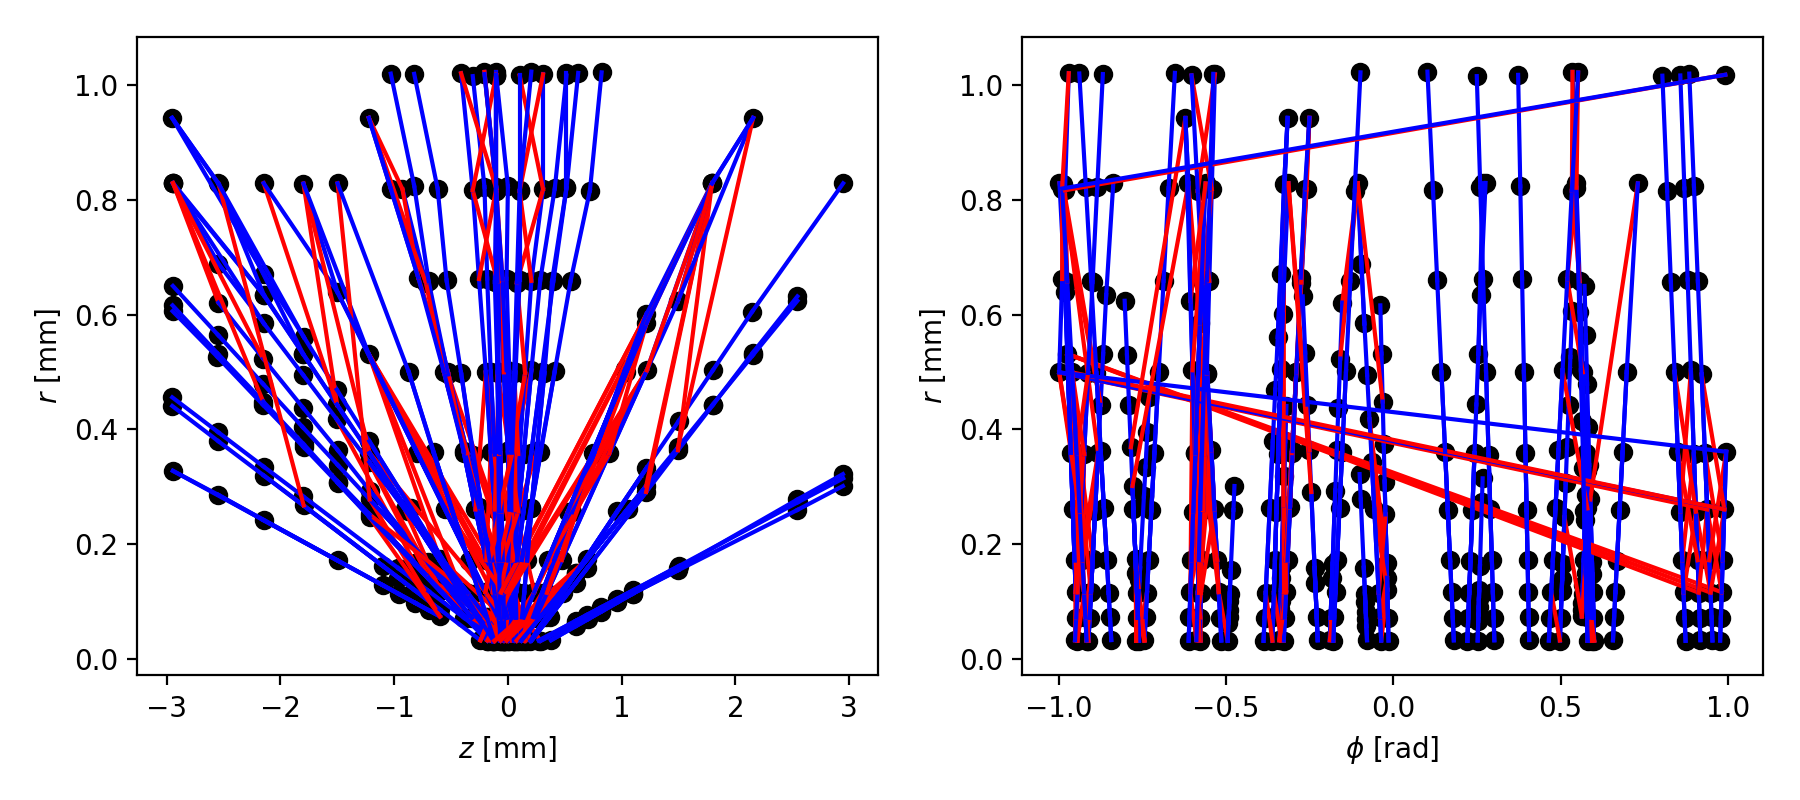

In [86]:
draw_sample(X, Ri, Ro, y)